In [3]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from CoolProp.HumidAirProp import HAPropsSI
from shutil import copyfile
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import matplotlib.pyplot as plt
from plot_id import *
plt.rcParams["font.family"] = "Liberation Sans"


In [8]:
path='~/Documents/greenair/python/Климат/data/'
file='Хабаровск.xls'
df = pd.read_excel(path+file, skiprows = 6)
title = re.sub('Местное время', 'Погода',df.columns[0])


In [9]:
df['data_time']=pd.to_datetime(df.iloc[:,0])
df['hour'] = df['data_time'].dt.hour
df['duration']=(df['data_time']-df['data_time'].shift()).fillna(pd.Timedelta(seconds=0))

In [10]:
d = []
h = []
for index, row in df.iterrows():
        try:
                W = HAPropsSI('W','T',row['T']+273.15,'P',101325,'R',row['U']/100)
        except:
                W = np.nan
        try:
                enthalpy = HAPropsSI('H','T',row['T']+273.15,'P',101325,'R',row['U']/100)/1000
        except:
                enthalpy = np.nan
        
        d.append(W)
        h.append(enthalpy)
        
df['d'] = d
df['h'] = h


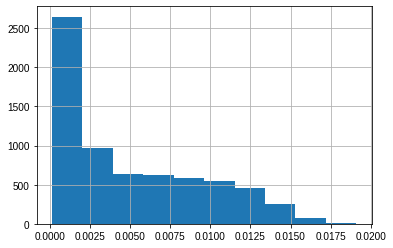

In [11]:
df['d'].hist()

In [12]:
title = re.sub('Местное время', 'Погода',df.columns[0])

**Осушение**

In [13]:
t_target  = 21 #degC
rh_target = 60 #%
l_nom     = 5500 #m3/h
ro        = 1.2 #kg/m3
d_drying = HAPropsSI('W','T',t_target+273.15,'P',101325,'R',rh_target/100)
h_drying = HAPropsSI('H','W',d_drying,'P',101325,'R',98/100)/1000

In [14]:
df.loc[:,'Mode']='Нагрев'
df.loc[(df['d']>=d_drying),'Mode']='Осушение'
df.loc[(df['d']<d_drying)&(df['T']>17),'Mode']='Охлаждение нерабочее'
df.loc[(df['d']<d_drying)&(df['hour']>8)&(df['hour']<19)&(df['T']>17),'Mode']='Охлаждение рабочее'

Text(0.5, 1.0, 'Погода в Хабаровске')

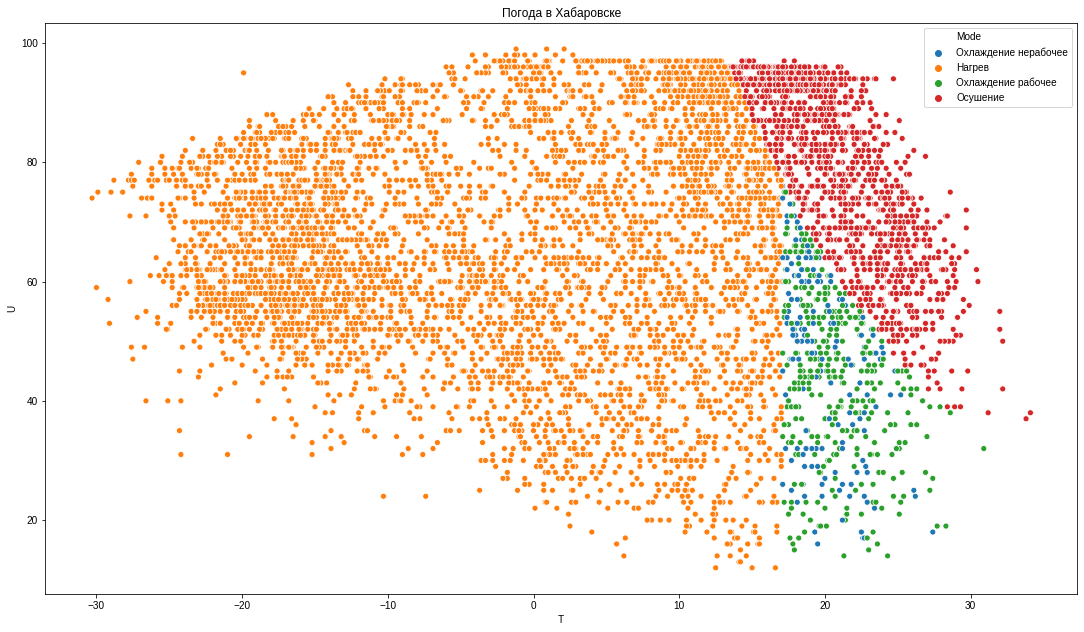

In [15]:
fig, ax = plt.subplots() 
fig.set_size_inches(18.5, 10.5)
sns.scatterplot(y='U',x='T', hue= 'Mode', data=df, ax=ax)
ax = plt.gca()
ax.set_title(title)

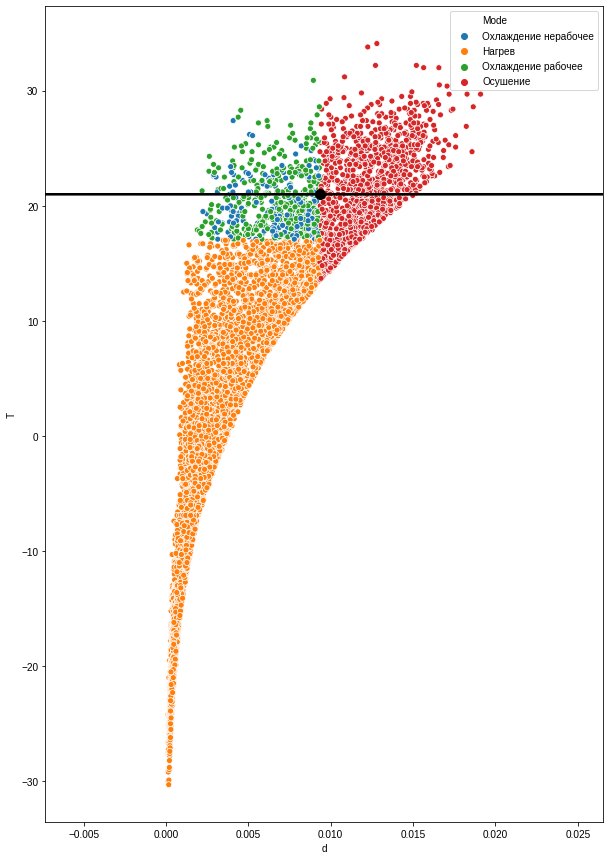

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 15)
#plot_id (ax)
sns.scatterplot(x='d', y='T', hue='Mode', data=df, ax=ax)
plt.plot([d_drying], [t_target], 'k.', markersize=20.0)
plt.show()

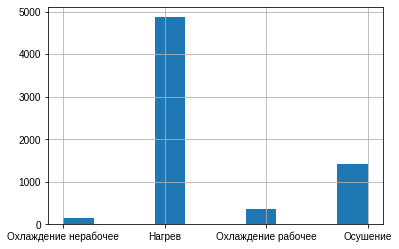

In [21]:
df['Mode'].hist()

In [125]:
def cooling_dry_cap_calc(row):
    if row['Mode'] == 'Осушение':
        cool_cap = l_nom/3600*ro*(row['h']-h_drying)
    else:
        cool_cap = 0
    return cool_cap

df['cooling_dry_cap']= df.apply(cooling_dry_cap_calc, axis = 1)


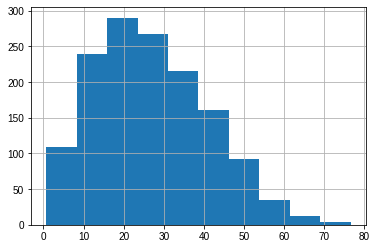

In [127]:
df.loc[df['Mode'] == 'Осушение','cooling_dry_cap'].hist()

Отбрасываем 3% максимальных мощностей и находим максимальную требуемую мощность охладителя, кВт

In [129]:
dryig_periods = df.loc[df['Mode'] == 'Осушение','cooling_dry_cap'].count()
df.loc[df['Mode'] == 'Осушение','cooling_dry_cap'].nlargest(int(dryig_periods*0.03), keep='all').min()

55.41093444339025

In [117]:
df.loc[,[df.columns[0],'T','U','d']]

,Местное время в Хабаровске,T,U,d
3354,18.07.2018 22:00,23.5,94.0,0.017253
3341,20.07.2018 13:00,27.0,70.0,0.015787
472,22.07.2019 01:00,24.2,88.0,0.016835
3309,24.07.2018 13:00,27.1,69.0,0.015650
3300,25.07.2018 19:00,23.4,94.0,0.017146
3278,28.07.2018 13:00,27.8,65.0,0.015352


In [9]:
df.loc[(df['U']>90) & (df['T']>20),[df.columns[0],'T','U','d']].describe()

,T,U,d
count,56.000000,56.000000,56.000000
mean,21.321429,93.160714,0.014951
std,1.039530,1.331804,0.001040
min,20.100000,91.000000,0.013640
25%,20.500000,92.000000,0.014132
50%,21.100000,93.000000,0.014838
75%,21.850000,94.000000,0.015487
max,24.700000,96.000000,0.018580


In [10]:
df.loc[(df['U']>75) & (df['T']>25),[df.columns[0],'T','U','d']]

,Местное время в Хабаровске,T,U,d
357,05.08.2019 22:00,26.1,82.0,0.017588
390,01.08.2019 16:00,25.7,81.0,0.016950
473,21.07.2019 22:00,25.1,87.0,0.017585
567,09.07.2019 10:00,25.5,80.0,0.016532
3260,30.07.2018 19:00,25.6,78.0,0.016206
3262,30.07.2018 13:00,25.3,84.0,0.017171
3264,30.07.2018 07:00,25.2,76.0,0.015400
3345,20.07.2018 01:00,25.2,79.0,0.016024
3348,19.07.2018 16:00,26.9,81.0,0.018231
3355,18.07.2018 19:00,25.8,78.0,0.016405


Text(0.5, 1, 'Погода в Хабаровске')

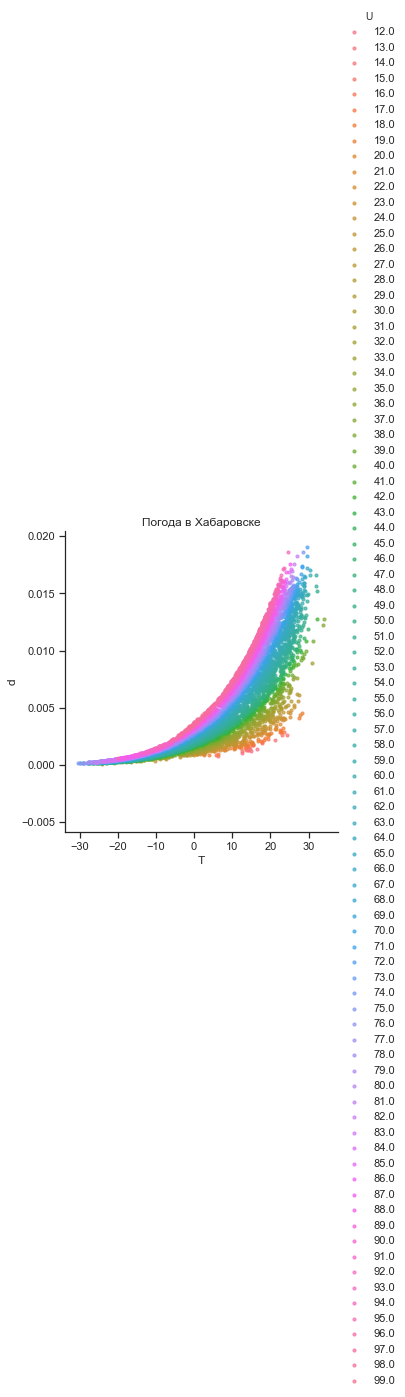

In [31]:
sns.lmplot(y='d',x='T', hue= 'U', data=df, fit_reg=False, scatter_kws={'alpha':0.7,'s': 10})
ax = plt.gca()
ax.set_title(title)


In [26]:
df.describe()

,T,Po,P,Pa,U,Ff,ff10,ff3,Tn,Tx,VV,Td,tR,Tg,d,h,Cушка
count,6815.000000,6817.000000,6815.000000,75.000000,6811.000000,6816.000000,255.000000,807.000000,986.000000,706.000000,5385.000000,6816.000000,1414.0,436.000000,6811.000000,6811.000000,6820.000000
mean,4.022465,750.177233,758.569024,-0.174667,66.404640,2.404196,11.615686,12.104089,-2.462880,7.699008,18.499044,-2.375484,12.0,9.380734,0.005003,16.701653,0.209091
std,14.941790,5.546881,5.871331,0.804564,19.549496,1.431510,1.688704,1.917419,14.569642,15.544811,4.112194,14.952193,0.0,7.105575,0.004447,25.392839,0.406689
min,-30.300000,728.200000,736.000000,-2.600000,12.000000,0.000000,10.000000,10.000000,-30.500000,-23.500000,0.050000,-36.500000,12.0,-13.000000,0.000131,-30.057244,0.000000
25%,-9.850000,746.500000,754.600000,-0.550000,53.000000,1.000000,10.000000,11.000000,-16.750000,-7.600000,20.000000,-15.800000,12.0,4.000000,0.001025,-7.157951,0.000000
50%,6.800000,750.100000,758.400000,-0.200000,67.000000,2.000000,11.000000,12.000000,-1.950000,11.050000,20.000000,-1.200000,12.0,10.500000,0.003487,15.745213,0.000000
75%,17.000000,754.000000,762.700000,0.300000,83.000000,3.000000,13.000000,13.000000,11.100000,21.575000,20.000000,11.400000,12.0,15.000000,0.008446,38.128032,0.000000
max,34.100000,767.500000,777.100000,1.700000,99.000000,9.000000,18.000000,21.000000,23.500000,31.000000,50.000000,24.100000,12.0,22.000000,0.019098,78.667778,1.000000


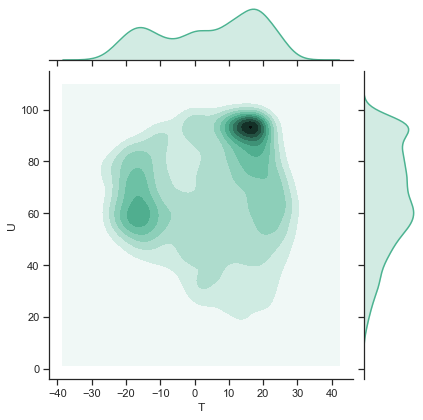

In [22]:
sns.set(style="ticks")

sns.jointplot(y='U',x='T', data=df, kind="kde", color="#4CB391")

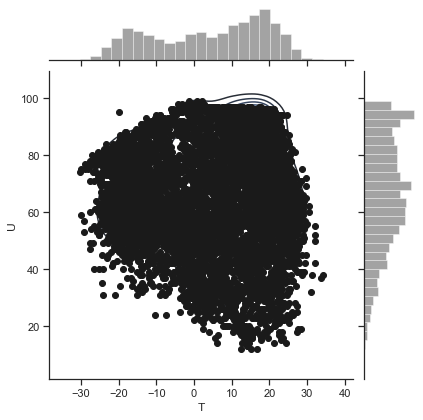

In [21]:
(sns.jointplot(y='U',x='T', data=df, color="k").plot_joint(sns.kdeplot, zorder=0, n_levels=6))

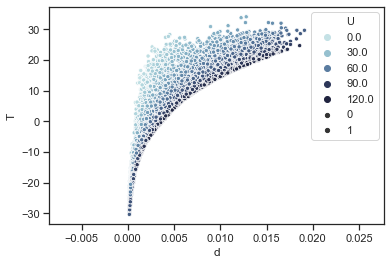

In [30]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x='d', y='T',
                     hue='U', size=1,
                     palette=cmap,
                     data=df)

In [115]:
df.iloc(3278)

ValueError: No axis named 3278 for object type <class 'pandas.core.frame.DataFrame'>

In [42]:
pd.to_datetime(df[0])


KeyError: 0